In [12]:
%reload_ext autoreload
%autoreload 2

#%matplotlib notebook
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt

import gtsam

# Wall detection: passing wall distance and/or angle estimates into GTSAM

Idea is to pass distance / angle estimates obtained from audio, to the drone

OUTSIDE: add wall estimate at 55.0cm, -90deg
OUTSIDE: add wall estimate at 92.0cm, -91deg
OUTSIDE: add wall estimate at 33.0cm, -91deg
OUTSIDE: add wall estimate at 89.0cm, -90deg
OUTSIDE: add wall estimate at 30.0cm, -90deg


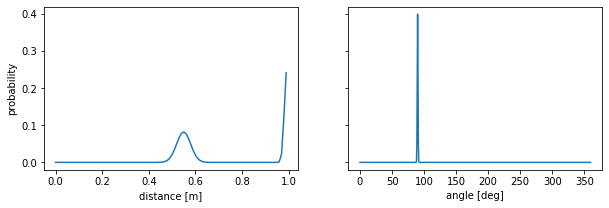

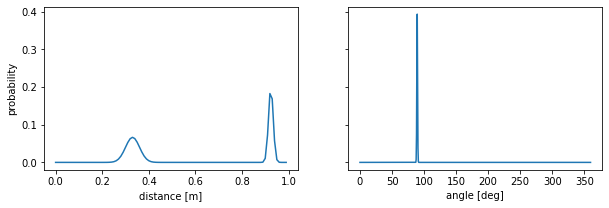

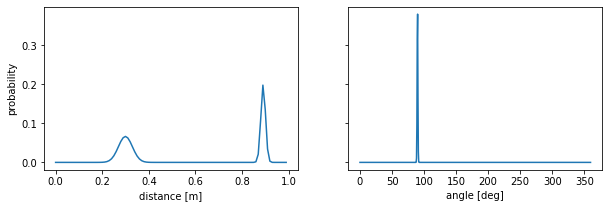

ISAM initial error: 476.0467685294219
ISAM final error: 1071.9794783437753
GncGaussNewton did not work.
Error message: 
Indeterminant linear system detected while working near variable
8070450532247928832 (Symbol: p0).

Thrown when a linear system is ill-posed.  The most common cause for this
error is having underconstrained variables.  Mathematically, the system is
underdetermined.  See the GTSAM Doxygen documentation at
http://borg.cc.gatech.edu/ on gtsam::IndeterminantLinearSystemException for
more information.
GN initial error: 476.0467685294219
GN final error: 1.783181565224797e+17
LM initial error: 476.0467685294219
LM final error: 476.0467685294219


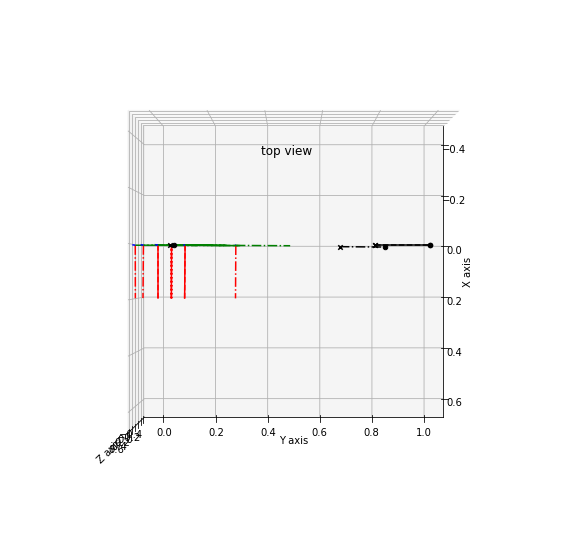

In [36]:
import sys
sys.path.append('../../src/audio_gtsam/')
from audio_gtsam.wall_backend import WallBackend, get_estimates
from helpers import WallSimulation, get_distribution, deg, rad
import scipy.signal
import itertools
import plot

np.random.seed(2)

P = gtsam.symbol_shorthand.P
X = gtsam.symbol_shorthand.X

times = np.linspace(0, 1, 3)
n_outliers = 1

wall_backend = WallBackend()

plane = gtsam.OrientedPlane3(gtsam.Unit3([0, -1.0, 0]), 1)
#pose_0 = gtsam.Pose3(t=gtsam.Point3(0, 0, 0), r=gtsam.Rot3.Ypr(30/180*np.pi, 0, 0))
pose_0 = gtsam.Pose3()
wall_simulation = WallSimulation()
wall_simulation.initialize(plane, pose_0)
wall_simulation.set_velocities(linear_m_s=0.1, yaw_deg_s=0)

ground_truth = gtsam.Values()
initial_estimate = gtsam.Values()

ground_truth.insert(P(0), plane)
initial_estimate.insert(P(0), plane)

graph = gtsam.NonlinearFactorGraph()

noise_model = gtsam.noiseModel.Isotropic.Sigma(6, 1.0)
plane_noise = gtsam.noiseModel.Diagonal.Sigmas([0.8, 0.8, 5])
huber_estimator = gtsam.noiseModel.mEstimator.Huber(1.3)
plane_noise_robust = gtsam.noiseModel.Robust(huber_estimator, plane_noise)
prior_factor = gtsam.PriorFactorOrientedPlane3(P(0), plane, plane_noise_robust)
graph.push_back(prior_factor)

for t, time in enumerate(times):
    wall_simulation.move_until_time(time)
    
    if t == 0:
        pose_t = wall_simulation.expected_pose()
    else:
        pose_t = wall_simulation.real_pose()
    #pose_t = wall_simulation.measure_pose()
    #pose_t = wall_simulation.expected_pose()
    ground_truth.insert(X(t), pose_t)
    initial_estimate.insert(X(t), pose_t)
    
    plane_meas, wall_angle, elevation, distance = wall_simulation.measure_plane()
    
    pose_factor = wall_backend.add_pose(r_world=pose_t.translation(), 
                          yaw=pose_t.rotation().yaw(),)
    graph.push_back(pose_factor)
    
    # angle to wall as we measure it (between 0 and 2pi)
    azimuth = np.pi + wall_angle
    
    distance_values, distance_prob = get_distribution(distance, [0, 1], n_outliers=n_outliers)
    angle_values, angle_prob = get_distribution(azimuth, [0, 2*np.pi], n_outliers=0)
    
    fig, axs = plt.subplots(1, 2, sharey=True)
    fig.set_size_inches(10, 3)
    axs[0].plot(distance_values, distance_prob)
    axs[0].set_ylabel('probability')
    axs[0].set_xlabel('distance [m]')
    axs[1].plot(angle_values * 180 / np.pi, angle_prob)
    axs[1].set_xlabel('angle [deg]')
    
    #print(distance_values)
    wall_backend.add_planes_from_distance_distribution(
        distance_values,  # cm
        distance_prob, 
        azimuth_deg=deg(azimuth), 
        azimuth_deg_std=deg(10)
    )
    distance_estimates, distance_stds = get_estimates(distance_values, distance_prob)
    angle_estimates, angle_stds = get_estimates(angle_values, angle_prob)
    #
    for d_i, a_i in itertools.product(range(len(distance_estimates)), 
                                    range(len(angle_estimates))):
        distance = distance_estimates[d_i]
        azimuth = angle_estimates[a_i]
        noise = [distance_stds[d_i], angle_stds[a_i], 0]
        wall_angle = azimuth - np.pi
        print(f"OUTSIDE: add wall estimate at {distance*100:.1f}cm, {deg(wall_angle):.0f}deg")
        plane_factor = wall_backend.add_plane(distance, wall_angle, plane_noise=noise)
        graph.push_back(plane_factor)
        # add noise to angle
        planes, poses = wall_backend.get_results()
plt.show()
#print(wall_backend.result.atPose3(X(t)))

plot_all(ground_truth, perspective=False, top=True, side=False)
plot_all(wall_backend.result, perspective=False, top=True, side=False, ls=":")

print("ISAM initial error:", graph.error(initial_estimate))
print("ISAM final error:", graph.error(wall_backend.result))

# throws linear exception
try:
    params = gtsam.GncGaussNewtonParams()
    opt = gtsam.GncGaussNewtonOptimizer(graph, initial_estimate, params)
    result = opt.optimize()
    plot_all(result, perspective=False, top=True, side=False, ls="--")
    print("Gnc initial error:", graph.error(initial_estimate))
    print("Gnc final error:", graph.error(result))
except Exception as e:
    print("GncGaussNewton did not work.")
    print("Error message:", e)

try:
    params = gtsam.GaussNewtonParams()
    opt = gtsam.GaussNewtonOptimizer(graph, initial_estimate, params)
    result = opt.optimize()
    plot_all(result, perspective=False, top=True, side=False, ls="-.")
    print("GN initial error:", graph.error(initial_estimate))
    print("GN final error:", graph.error(result))
except Exception as e:
    print("GaussNewton did not work.")
    print("Error message:", e)
    
try:
    params = gtsam.LevenbergMarquardtParams()
    opt = gtsam.LevenbergMarquardtOptimizer(graph, initial_estimate, params)
    result = opt.optimize()
    plot_all(result, perspective=False, top=True, side=False, ls="--")
    print("LM initial error:", graph.error(initial_estimate))
    print("LM final error:", graph.error(result))
except Exception as e:
    print("LevenbergMarquardt did not work.")
    print("Error message:", e)

#plot.plot_trajectory(2, ground_truth, ls=":", axis_length=0.2)
#plt.show()
plt.show()

In [22]:
params = gtsam.GaussNewtonParams()

# DOA algorithms: passing spatial spectrum into GTSAM

Idea is to pass multiple sidelobes from spectrum as individual measurements to the same sound source.  

In [ ]:
noiseModel.F